# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [ ]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

In [ ]:
import numpy as np
from clearml import Logger, Task
from typing import List
import matplotlib.pyplot as plt

In [3]:
%load_ext memory_profiler

# Dataset loading


In [5]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

zsh:1: command not found: wget


In [7]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
# the environment variables, to run this fill in the access key and secret key, and uncomment the lines with keys

%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=...
# %env CLEARML_API_SECRET_KEY=...

In [ ]:
# to run this, run above cell

task = Task.init(project_name="ProxProp", task_name="Tests")
logger = task.get_logger()

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [8]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [11]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="Standard Network Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="Standard Network Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0982, Loss: 14.80497988224913
Epoch: 1, Accuracy: 0.7821, Loss: 1.3941544817463105
Epoch: 2, Accuracy: 0.8529, Loss: 0.6491539678511694


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 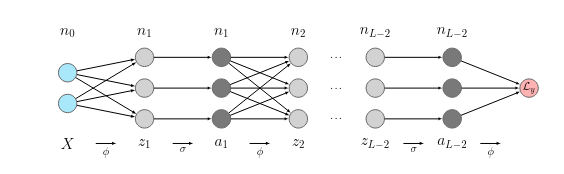)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 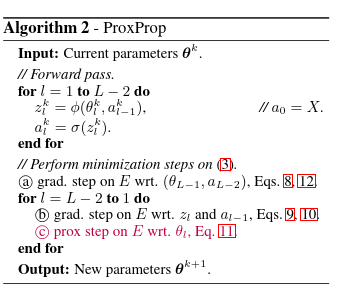)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 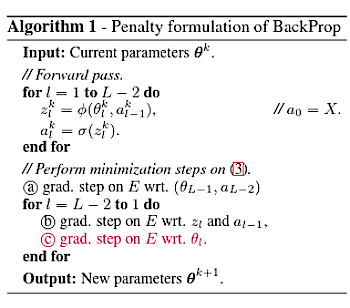)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

---
Calculations:
$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

Let
$$
J(W) = \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
$$

To find optimal $W$, we minimize $J(W)$ w.r.t. $W$.

1. First rewrite $J(W)$, expanding norm terms.
$$
\begin{equation}
J(W) = \frac{1}{2} (W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*})^T(W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*}) +  \frac{1}{2\eta}(W - W^{(l)})^T(W - W^{(l)})
\end{equation}
$$

 Let:

 $E_1 = W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*}$

 $E_2 = W - W^{(l)}$

2. Taking derivatives of $E_1, E_2$ w.r.t. to $W$.

  (a) $\frac {\partial E_1}{\partial W} = g^{(l-1)^T}$, and therefore $ \frac{\partial}{\partial W} ( E_1^TE_1)  = 2 E_1 \cdot g^{(l-1)^T}$

  (b) $\frac {\partial }{\partial W} (E_2^TE_2)  = 2(W - W^{(l)})$


3. Minimizing $J(W)$ <- setting derivative of $J(W)$ w.r.t. W to zero.

  $\frac {\partial J(W)}{\partial W} =  (W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*}) \cdot g^{(l-1)^T} + \frac{1}{\eta}(W - W^{(l)}) = 0$.

  From this we get:

  $$
  W = \big((f^{(l)}_{*} - b^{(l)}) \cdot g^{(l-1)^T} + \frac{1}{\eta}W^{(l)}\big)\big(g^{(l-1)}g^{(l-1)^T} + \frac{1}{\eta}I \big)^{-1}
  $$


In [ ]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        ### Your code goes here ###
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        ###########################

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        ### Your code goes here ###

        # Run the network on a batch of cases of shape: (layer_0, B).
        # Returns last layer activations, shape: (layer_last, B)

        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a
        ###########################

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        ### Your code goes here ###

        # Backprop for a mini batch
        # Args:
        # - x: input, shape (layer_0, B)
        # - y: target label (one-hot encoded), shape (layer_last, B)
        # - eta: learning rate

        # Returns loss

        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = w @ g + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        # Shapes of gs: (layer_0, B), (layer_1, B), ..., (layer_last, B)
        # Shapes of fs:               (layer_1, B), ..., (layer_last, B)

        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y) # shape: (layer_last, B)

        g_proxy = gs[-1] - eta * dLdg # shape: (layer_last, B)

        new_b = []
        new_w = []

        for w, b, f, g, g_prev in reversed(list(zip(self.weights, self.biases, fs, gs[1:], gs[:-1]))):

            # We will use this in two places (for dLdf and f_proxy).
            # Shape: (layer_i, B)
            sigmoid_prime_f = np.multiply(g, 1 - g)

            # dl / df = dl / dg * dg / df = dl / dg * sigmoid_prime
            # So dl / dg shape is (layer_i, B),
            # g shape is (layer_i, B).
            # We do element wise multiplication getting shape: (layer_i, B).
            dLdf = np.multiply(dLdg, sigmoid_prime_f)

            # Now update for dl / dg <- if we are in i layer, then we are calculating this for i-1 layer.
            # dl / dg = dl / df * df / dg =
            #         = dl / df * W
            # Shapes:
            # dl / df has shape: (layer_i, B),
            # W has shape: (layer_i, layer_(i-1)).
            # We multiply matrices: W.T @ dldf, getting shape: (layer_(i-1), B).
            dLdg = np.matmul(w.T, dLdf)

            # dL / dB = dL / df * df / dB =
            #         = dL / df
            # Shapes:
            # dl / df has shape: (layer_i, B).
            # so we have B inputs and we want to sum it across these inputs, to obtain the values for biases,
            # and we get the shape: (later_i, ) <- numpy vector (without describing whether it is vertical or horizontal).
            # Reshape for shape: (later_i, 1)
            dLdB = np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1)

            # New bias for the layer, just like in standard backprop.
            updated_b = b - (eta / x.shape[1]) * dLdB
            new_b.append(updated_b)

            # f_proxy = f - dg / df * (g - g_proxy) =
            #         = f - sigmoid_prime * (g - g_proxy)
            # Shapes:
            # f has shape: (layer_i, B),
            # g has shape: (layer_i, B),
            # g_proxy has shape: (layer_i, B).
            # We do element wise multiplication, getting shape: (layer_i, B)
            f_proxy = f - np.multiply(sigmoid_prime_f, (g - g_proxy))

            # Now calculate new W for the layer.
            # So the equation for W is:
            # new_w = ((f_proxy - updated_b) * (g_prev)^T + 1 / eta * w) * (g_prev * (g_prev)^T + 1 / eta * I)^(-1)

            # We use solve instead of inv, because it's faster.
            # It is solving: AX = B, so multiplying by A^(-1) on the left we get: X = A^(-1)B.
            # But we want X = BA^(-1), so we do A^TX = B^T, getting X = (A^T)^(-1)B^T = (A^(-1))^T B^T,
            # by the properties of transpose. And at the end we transpose it, getting: X^T = BA^(-1), as we wanted.
            first_term = (f_proxy - updated_b) @ g_prev.T + 1 / eta * w

            g_prev_square = g_prev @ g_prev.T
            identity_matrix = np.eye(g_prev_square.shape[0])
            second_term = g_prev_square + 1 / eta * identity_matrix

            new_w_term = np.linalg.solve(second_term.T, first_term.T).T
            new_w.append(new_w_term)

            # g_proxy = g - df / dg * (f - f_proxy)
            # as we calculated g_proxy before the for loop, now we update it, just like dl / dg
            # <- if we are in i layer, then we calculating this for i-1 layer.
            # g_prev shape: (layer_(i-1), B),
            # f shape: (layer_i, B),
            # f_proxy shape: (layer_i, B),
            # w shape: (layer_i, layer_(i-1)).
            # We multiply matrices: w.T @ (f - f_proxy), getting shape: (layer_(i-1), B).
            g_proxy = g_prev - np.matmul(w.T, f - f_proxy)

        new_b.reverse()
        new_w.reverse()

        self.biases = new_b
        self.weights = new_w

        return loss
        ###########################

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )



# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

# Train the network

In [ ]:
# random train without seed
network_prox = ProxProp([784, 128, 128, 64, 64, 10])
network_prox.SGD(
    (x_train, y_train),
    epochs=10,
    mini_batch_size=50,
    eta=6.0,
    test_data=(x_test, y_test),
)

In [ ]:
### Your code goes here ###

# Compare with the same seed
np.random.seed(1234)
network_prox = ProxProp([784, 128, 128, 64, 64, 10])
network_prox.SGD(
    (x_train, y_train),
    epochs=25,
    mini_batch_size=50,
    eta=6.0,
    test_data=(x_test, y_test),
    logger=logger,
)

np.random.seed(1234)
network_standard = Network([784, 128, 128, 64, 64, 10])
network_standard.SGD(
    (x_train, y_train),
    epochs=25,
    mini_batch_size=50,
    eta=6.0,
    test_data=(x_test, y_test),
    logger=logger,
)
###########################

# Training plots for the best training

Architecture and parameters:
- Layers: 784 - 128 - 128 - 64 - 64 - 10
- eta: 6.0
- batch size: 50

ProxyProp clearly outperforms standard backpropagation in this setup. While ProxyProp quickly learns and hits over 94% accuracy in just a few epochs, the standard network barely improves and seems stuck, with accuracy staying low and loss staying high.

---
Now code for getting scalars from ClearML and plotting it using matplotlib.

In [ ]:
# Gets the scalars data from the clearml task; to run this, run the setup clearml cells

scalars_data = task.get_reported_scalars()

loss_standard = scalars_data['Loss']['Standard Network Loss']
loss_standard_x = loss_standard['x']
loss_standard_y = loss_standard['y']

loss_proxy = scalars_data['Loss']['ProxyProp Loss']
loss_proxy_x = loss_proxy['x']
loss_proxy_y = loss_proxy['y']

accuracy_standard = scalars_data['Accuracy']['Standard Network Accuracy']
accuracy_standard_x = accuracy_standard['x']
accuracy_standard_y = accuracy_standard['y']

accuracy_proxy = scalars_data['Accuracy']['ProxyProp Accuracy']
accuracy_proxy_x = accuracy_proxy['x']
accuracy_proxy_y = accuracy_proxy['y']


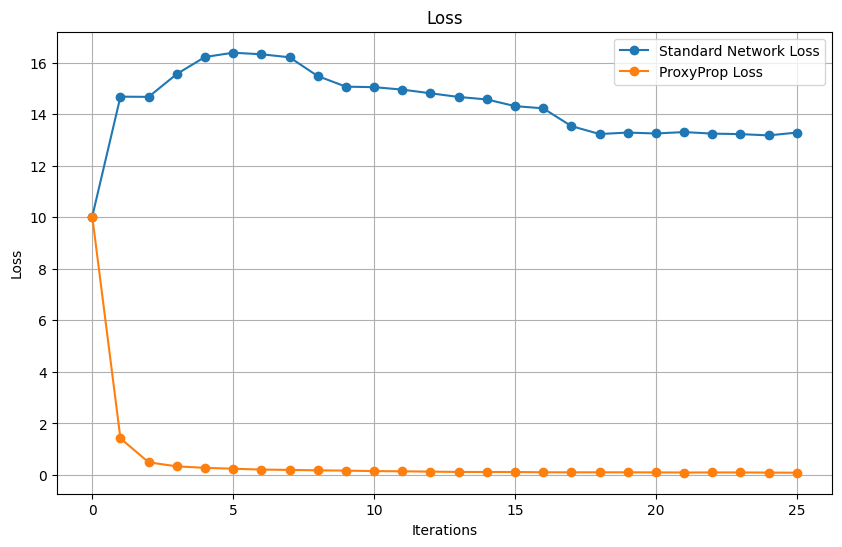

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss_standard_x, loss_standard_y, label="Standard Network Loss", marker='o')
plt.plot(loss_proxy_x, loss_proxy_y, label="ProxyProp Loss", marker='o')
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Comparison of ProxyProp and Standard Backpropagation Loss:

The plot shows two lines — ProxyProp with a rapidly decreasing loss near the bottom, while the standard backprop line staying at a high value, indicating poor optimization.

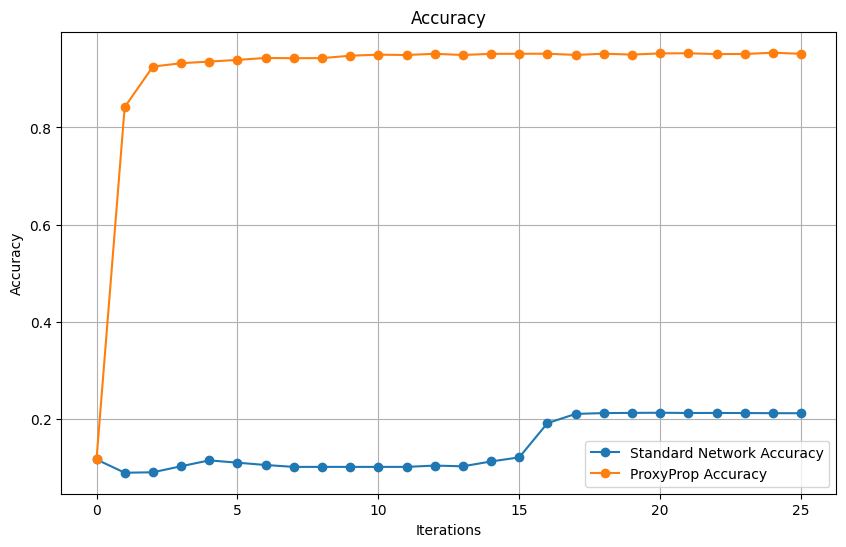

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(accuracy_standard_x, accuracy_standard_y, label="Standard Network Accuracy", marker='o')
plt.plot(accuracy_proxy_x, accuracy_proxy_y, label="ProxyProp Accuracy", marker='o')
plt.title("Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

Comparison of ProxyProp and Standard Backpropagation Accuracy:

The plot shows two lines — ProxyProp consistently achieving high accuracy near the top, while the standard backprop line remains flat at the bottom due to poor learning performance.

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [ ]:
### Your code goes here ###
# compare with the same seed, but here it doesn't make any difference

def train_net_standard_mem():
  np.random.seed(42)
  network_standard = Network([784, 100, 100, 100, 10])
  network_standard.SGD(
      (x_train, y_train),
      epochs=5,
      mini_batch_size=50,
      eta=3.0,
      test_data=(x_test, y_test),
  )

def train_net_prox_mem():
  np.random.seed(42)
  network_prox = ProxProp([784, 100, 100, 100, 10])
  network_prox.SGD(
      (x_train, y_train),
      epochs=5,
      mini_batch_size=50,
      eta=3.0,
      test_data=(x_test, y_test),
  )

%memit train_net_standard_mem()
%memit train_net_prox_mem()
###########################

We can observe a slight difference in memory usage. In standard backpropagation, gradients $\frac {\partial L}{\partial f}$ are stored at each layer. In contrast, ProxyProp temporarily stores new values for biases and weights as it iterates through the layers, which are then used to update the parameters (my implementation of ProxyProp bacpropagation).

---


It's understandable that the memory usage for the standard network and ProxyProp are close to each other. In ProxyProp, we don't use significantly more or less memory for storing model parameters such as activations, gradients, etc; so the memory footprint remains similar. However, if a memory-optimizing technique like checkpointing were used, we would likely observe a more substantial reduction in memory usage, as checkpointing saves memory by retaining only select layer activations instead of all.
